# Neural ODE

In [1]:
# TODO: Replace print with logging

# see https://towardsdatascience.com/deep-study-of-a-not-very-deep-neural-network-part-2-activation-functions-fd9bd8d406fc

# Plot all activation function together to visually see the differences.
# Comment on which that is differentable and whoes not - What is the pros of treating a differentable/non-differentable activation function?


# Make all plots possible to save
# Move all parameters to params.py file, that we load into the run script/notebook
# then, create a main script that run all the different models, and save the model object after training.

In [2]:
# NOTE:
# med spiral dataset fungerer hidden_dim = 3, og man kan da plotte resultatet i 3d. Nettverket fungerer ikke for cirkel data.


# ut fungerer ikke med rk4, men fungerer fint med euler for cirkel data. Følgende separerer prikkene bra. Men hvorfor er de ikke alltid separert SELV OM modellen predikerer korrekt?
# hidden_dim = 16
# hidden_internal_dim = 24 # internal dim in y' : p in (p x m)
# num_hidden_layers = 10 # number of time steps
# method = ["neural", "euler", "rk4"][1]
# variant = ["standard", "UT"][1]

# helt likt fungerer ikke for sprial data, men dersom man ender til standard metode fungerer det for spiral
# hidden_dim = 16
# hidden_internal_dim = 24 # internal dim in y' : p in (p x m)
# num_hidden_layers = 10 # number of time steps
# method = ["neural", "euler", "rk4"][1]
# variant = ["standard", "UT"][0]

### 1. SETUP

Import useful packages and pre-defined helper functions

In [3]:
import torch
import torch.nn as nn

import utilities as utilities
import params as params
import networks as networks

Set parameters

In [4]:
model_kwargs = params.shallow_kwargs_dict["Shallow Euler UT m≠p"]
dataset_type = params.dataset_types[0]

Model SetUp

In [5]:
# Model Activation Functions
activation_functions = [
    nn.ReLU,
    nn.Sigmoid,
    nn.SiLU,
    nn.Tanh,
    nn.ELU,
    nn.Hardsigmoid,
    nn.GELU,
]

# Model Optimizer
model_optimizer = torch.optim.SGD

# Model Loss Function
model_lossfn = nn.BCELoss
# NOTE: nn.BCELoss has no sigmoid built-in
# Require inputs to have gone through the sigmoid activation function prior

# PRINT Chosen Model Arcithecture
# hidden_dim: m
# hidden_internal_dim: p in (p x m)
# num_hidden_layers: number of time steps
# method: "neural", "euler", "rk4"
# variant: "standard", "UT"
print(
    f"Used model kwargs for {model_kwargs['name']}: \n"
    f"\tMETHOD: {model_kwargs['method']}\n"
    f"\tVARIANT: {model_kwargs['variant']}\n"
    f"\t# time steps: {model_kwargs['num_hidden_layers']}\n"
    f"\tm dim: {model_kwargs['hidden_dim']}\n"
    f"\tp dim: {model_kwargs['hidden_internal_dim']}\n"
)

Used model kwargs for Shallow Euler UT ODE w/ m≠p: 
	METHOD: euler
	VARIANT: UT
	# time steps: 3
	m dim: 10
	p dim: 32



### 2. Load and prepare dataset

Shape of synthetic dataset (X, y): (torch.Size([4000, 2]), torch.Size([4000]))


/Users/martineh/anaconda3/envs/resnet/lib/python3.9/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


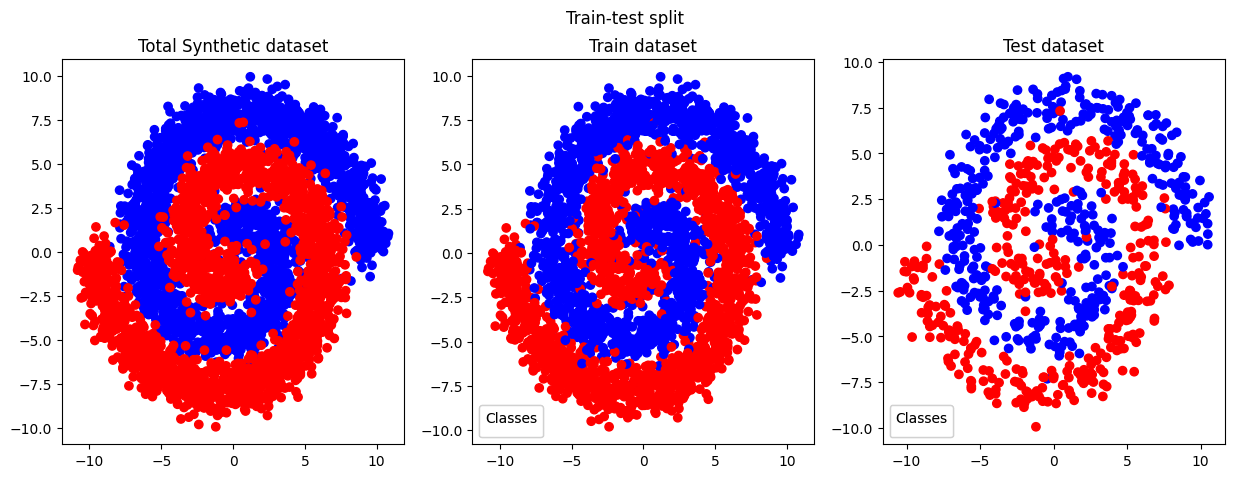

In [6]:
# Load dataset (X, y)
if dataset_type == "spiral":
    # Sprial data
    X, y = utilities.generate_spiral_data(params.n_points, noise=0.8, degree=540)

elif dataset_type == "circle":
    # Circle data
    X, y = utilities.generate_circle_data(params.n_points, noise=0.1, factor=0.8)

else:
    raise ValueError(
        f"Dataset type {dataset_type} is not defined. Please try another type!"
    )

# Load to torch tensor
# Train test split
(
    train_dataloader,
    test_dataloader,
    train_data,
    test_data,
    X_train,
    y_train,
    X_test,
    y_test,
) = utilities.get_dataloader_from_numpy_dataset(
    X, y, color_label_dict=params.color_label_dict, fig_show=True
)

# Get dim of data
input_dim = X.shape[-1]
if len(y.shape) == 1:
    output_dim = 1
else:
    output_dim = y.shape[-1]
print(f"dim of input data: {input_dim}")
print(f"dim of output data: {output_dim}")

### 3. Training

In [9]:
setup_kwargs = {
    "ModelODE": networks.NeuralODE,
    "model_lossfn": model_lossfn,
    "model_optimizer": model_optimizer,
    "input_dim": input_dim,
    "output_dim": output_dim,
}

data_kwargs = {
    "train_dataloader": train_dataloader,
    "test_dataloader": test_dataloader,
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}

plotting_kwargs = {
    "fig_show": True,
    # "fig_save": True,
    # "fig_fname": f"{model_kwargs['name']}.png",
}


Activation function ReLU:

----> EPOCH 0 of 50:
Train loss: 1.15371 | Train accuracy: 63.97%
Test loss: 37.62500 | Test accuracy: 62.38%

----> EPOCH 1 of 50:
Train loss: 0.59201 | Train accuracy: 64.47%
Test loss: 48.87500 | Test accuracy: 51.12%

----> EPOCH 2 of 50:
Train loss: 0.56804 | Train accuracy: 65.38%
Test loss: 35.37500 | Test accuracy: 64.62%

----> EPOCH 3 of 50:
Train loss: 0.53009 | Train accuracy: 69.16%
Test loss: 24.00000 | Test accuracy: 76.00%

----> EPOCH 4 of 50:
Train loss: 0.48324 | Train accuracy: 73.53%
Test loss: 29.75000 | Test accuracy: 70.25%

----> EPOCH 5 of 50:
Train loss: 0.43373 | Train accuracy: 78.78%
Test loss: 19.62500 | Test accuracy: 80.38%

----> EPOCH 6 of 50:
Train loss: 0.39385 | Train accuracy: 83.75%
Test loss: 29.50000 | Test accuracy: 70.50%

----> EPOCH 7 of 50:
Train loss: 0.36037 | Train accuracy: 85.12%
Test loss: 20.50000 | Test accuracy: 79.50%

----> EPOCH 8 of 50:
Train loss: 0.32785 | Train accuracy: 87.38%
Test loss: 12.7500

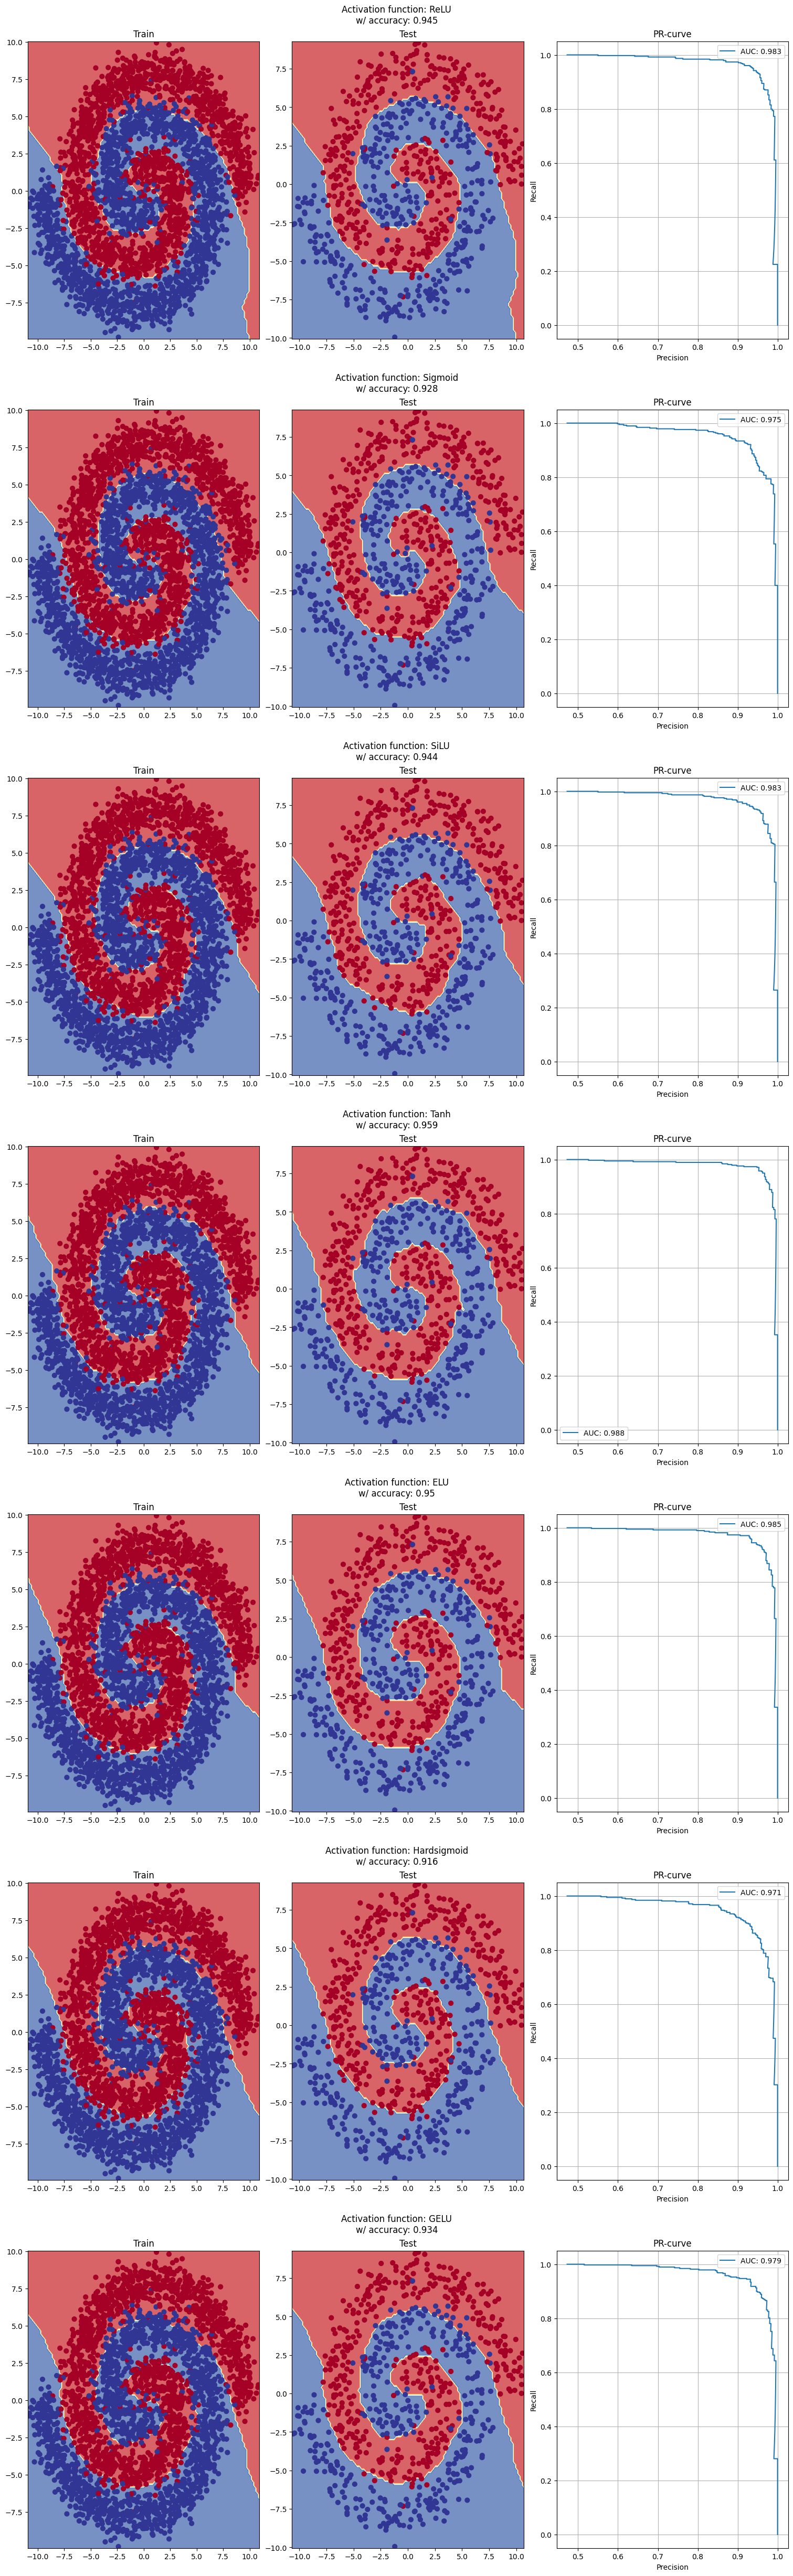

In [10]:
model_object_dict = utilities.run_model(
    activation_functions=activation_functions,
    **model_kwargs,
    **setup_kwargs,
    **data_kwargs,
    **plotting_kwargs
)

## Plot transformation of X points through time stepping

Choose model activation function to investigate

In [11]:
plot_model = model_object_dict["ReLU"]

Plot 3D, 2D and metric plots

In [12]:
# 3D plot for transformation with time stepping
utilities.plot_transformation_3d(
    x_transformed_reduced=plot_model.x_transformed_reduced,
    color_transformed_reduced=plot_model.color_transformed_reduced,
    static=False,
    interactive=True,
)

# 2D plot for transformation with time stepping
utilities.plot_transformation_2d(
    x_transformed_reduced=plot_model.x_transformed_reduced,
    color_transformed_reduced=plot_model.color_transformed_reduced,
    show_decision_boundary=True,
    model=plot_model,
)

# Loss, accuracy and confusion matrix
utilities.plot_evaluation_score(
    plot_model.train_loss_per_epoch,
    plot_model.test_loss_per_epoch,
    plot_model.train_acc_per_epoch,
    plot_model.test_acc_per_epoch,
    plot_model.confusion_matrix,
)